In [10]:
import warnings
import pandas as pd
import numpy as np
import yfinance as yf
% matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [11]:
# Arithmetic Expectancy Formula
def expectancy(win_rate, avg_win, avg_loss):
    """
    :param win_rate: Hit ratio
    :param avg_win: Average gain per trade
    :param avg_loss: Average loss per trade
    :return: Arithmetic expectancy
    """
    return win_rate * avg_win + (1 - win_rate) * avg_loss

In [12]:
# Geometric Gain Expectancy
def george(win_rate, avg_win, avg_loss):
    """
    :param win_rate: Hit ratio
    :param avg_win: Average gain per trade
    :param avg_loss: Average loss per trade
    :return: Geometric expectancy
    """
    return (1 + avg_win) ** win_rate * (1 + avg_loss) ** (1 - win_rate) - 1

In [14]:
# Kelly Criterion
def kelly(win_rate, avg_win, avg_loss):
    """
    :param win_rate: Hit ratio
    :param avg_win: Average gain per trade
    :param avg_loss: Average loss per trade
    :return: Kelly criterion
    """
    return win_rate / np.abs(avg_loss) - (1 - win_rate) / avg_win

In [15]:
# Regime Breakout
def regime_breakout(df, _h, _l, window):
    hl = np.where(df[_h] == df[_h].rolling(window).max(), 1,
                  np.where(df[_l] == df[_l].rolling(window).min(), -1, np.nan))
    roll_hl = pd.Series(index=df.index, data=hl).fillna(method='ffill')
    return roll_hl

In [16]:
# Turtle Trader
def turtle_trader(df, _h, _l, slow, fast):
    # _slow: Long/Short direction
    _slow = regime_breakout(df, _h, _l, window=slow)

    # _fast: Trailing stop loss
    _fast = regime_breakout(df, _h, _l, window=fast)
    turtle = pd.Series(index=df.index,
                       data=np.where(_slow == 1, np.where(_fast == 1, 1, 0),
                                     np.where(_slow == -1, np.where(_fast == -1, -1, 0), 0)))
    return turtle

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': '9984.T Daily P&L & Cumulative P&L'}, xlabel='Date'>

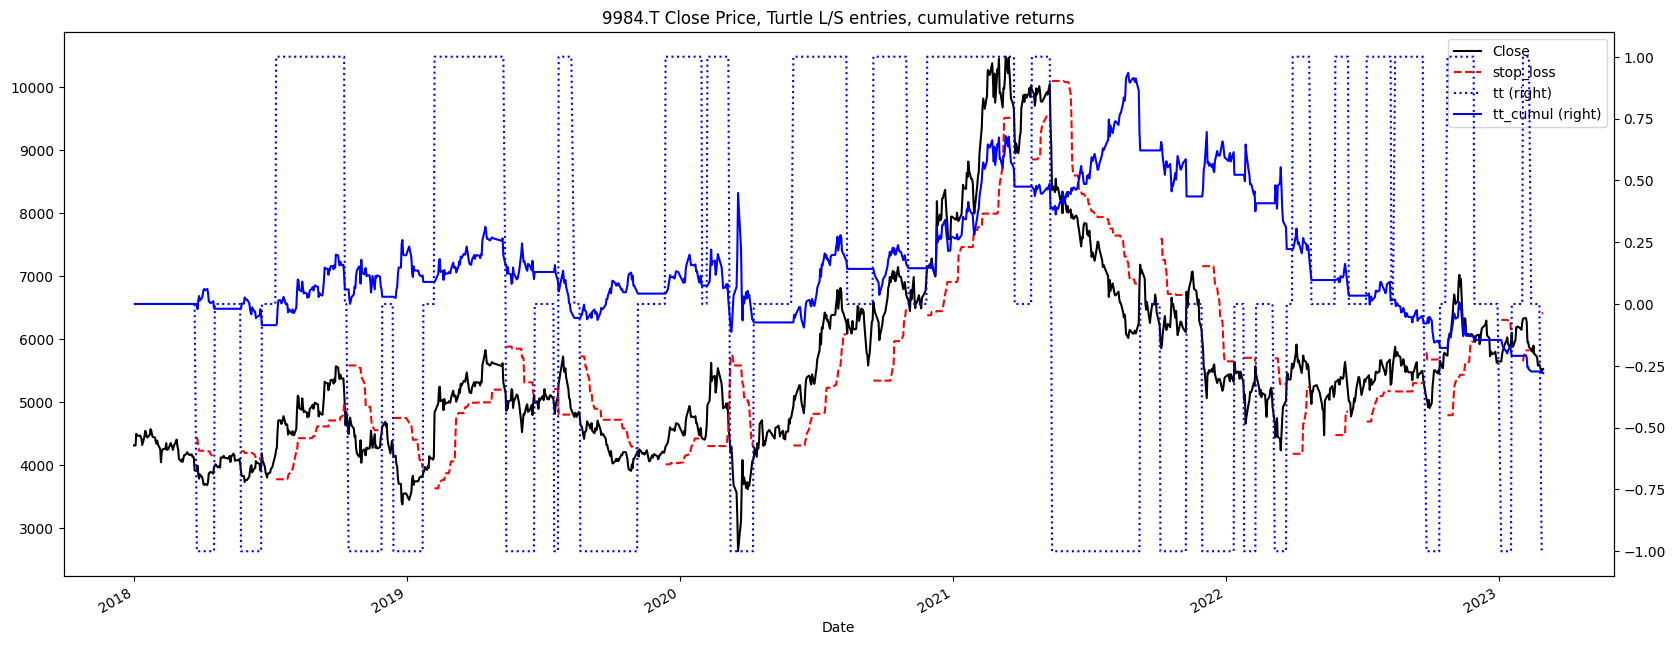

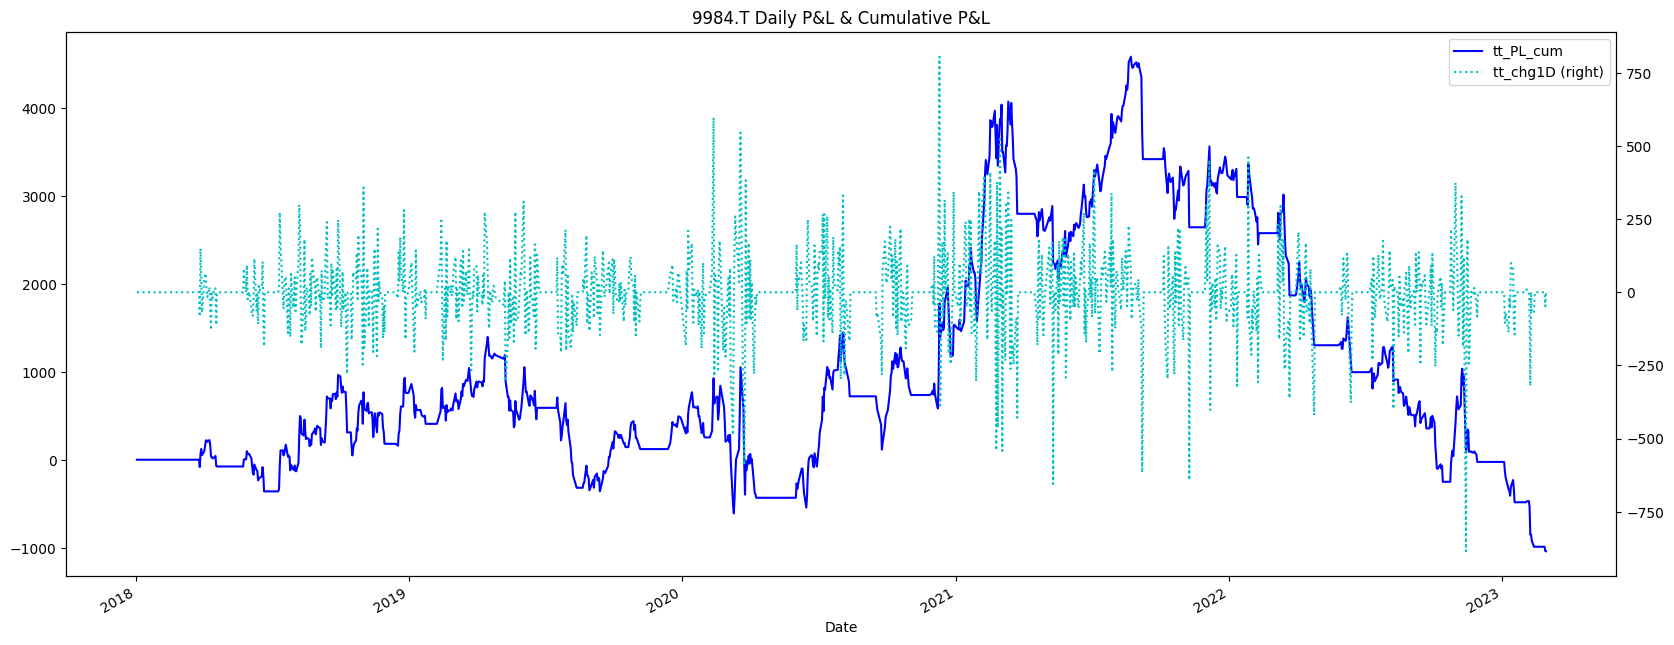

In [18]:
# Run Softbank through Turtle Trader strategy, calculate returns, print out charts
ticker = '9984.T'  # Softbank
start = '2017-12-31'
end = None
df = round(yf.download(tickers=ticker, start=start, end=end,
                       interval="1d", group_by='column',
                       auto_adjust=True, prepost=True,
                       threads=True, proxy=None), 0)
slow = 50
fast = 20
df['tt'] = turtle_trader(df, _h='High', _l='Low', slow=slow, fast=fast)
df['stop_loss'] = np.where(df['tt'] == 1, df['Low'].rolling(fast).min(),
                           np.where(df['tt'] == -1, df['High'].rolling(fast).max(), np.nan))

df['tt_chg1D'] = df['Close'].diff() * df['tt'].shift()
df['tt_PL_cum'] = df['tt_chg1D'].cumsum()

df['tt_returns'] = df['Close'].pct_change() * df['tt'].shift()
tt_log_returns = np.log(df['Close'] / df['Close'].shift()) * df['tt'].shift()
df['tt_cumul'] = tt_log_returns.cumsum().apply(np.exp) - 1

df[['Close', 'stop_loss', 'tt', 'tt_cumul']].plot(secondary_y=['tt', 'tt_cumul'],
                                                  figsize=(20, 8), style=['k', 'r--', 'b:', 'b'],
                                                  title=str(
                                                      ticker) + ' Close Price, Turtle L/S entries, cumulative returns')

df[['tt_PL_cum', 'tt_chg1D']].plot(secondary_y=['tt_chg1D'],
                                   figsize=(20, 8), style=['b', 'c:'],
                                   title=str(ticker) + ' Daily P&L & Cumulative P&L')

<Axes: title={'center': 'trading_edge, geometric_expectancy, kelly'}, xlabel='Date'>

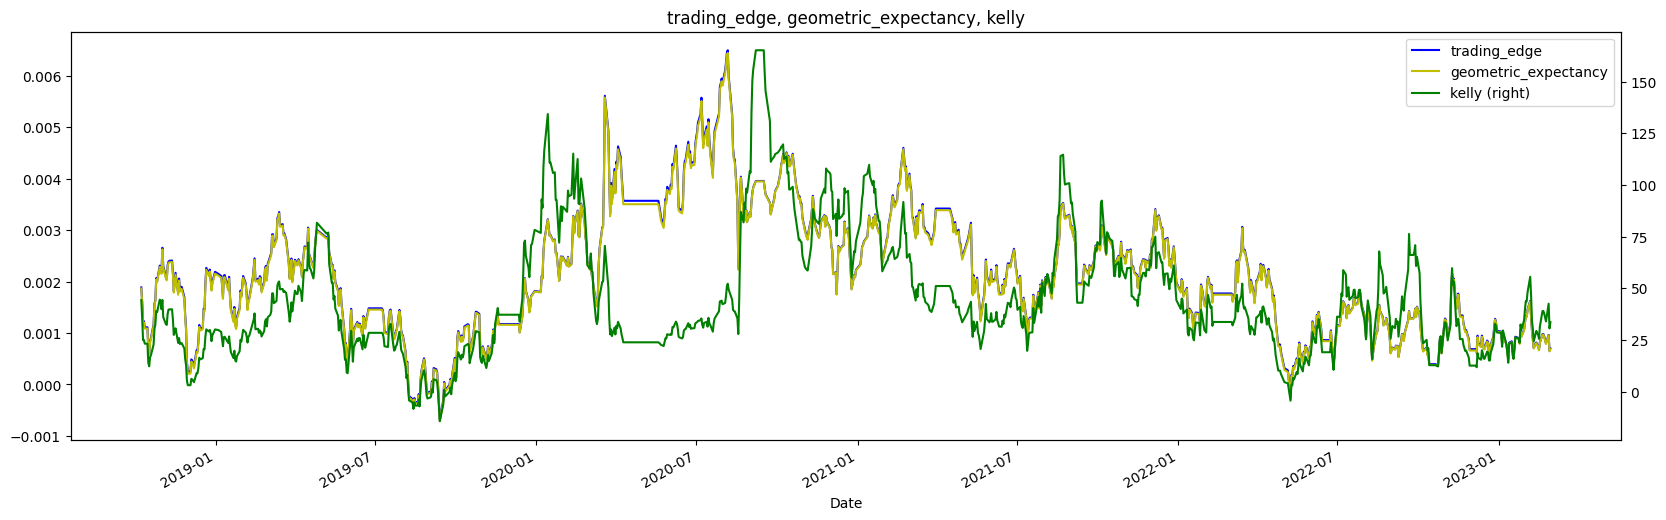

In [19]:
# Separate profits from losses
loss_roll = tt_log_returns.copy()
loss_roll[loss_roll > 0] = np.nan
win_roll = tt_log_returns.copy()
win_roll[win_roll < 0] = np.nan

# Calculate rolling win/loss rates and averages
window = 100
win_rate = win_roll.rolling(window).count() / window
loss_rate = loss_roll.rolling(window).count() / window
avg_win = win_roll.fillna(0).rolling(window).mean()
avg_loss = loss_roll.fillna(0).rolling(window).mean()

# Calculate expectancies
df['trading_edge'] = expectancy(win_rate, avg_win, avg_loss).fillna(method='ffill')
df['geometric_expectancy'] = george(win_rate, avg_win, avg_loss).fillna(method='ffill')
df['kelly'] = kelly(win_rate, avg_win, avg_loss).fillna(method='ffill')

df[window * 2:][['trading_edge', 'geometric_expectancy', 'kelly']].plot(
    secondary_y=['kelly'], figsize=(20, 6), style=['b', 'y', 'g'],
    title='trading_edge, geometric_expectancy, kelly')

<Axes: title={'center': '9984.T cumulative returns, Profit Ratio, cumulative &  rolling 252 days'}, xlabel='Date'>

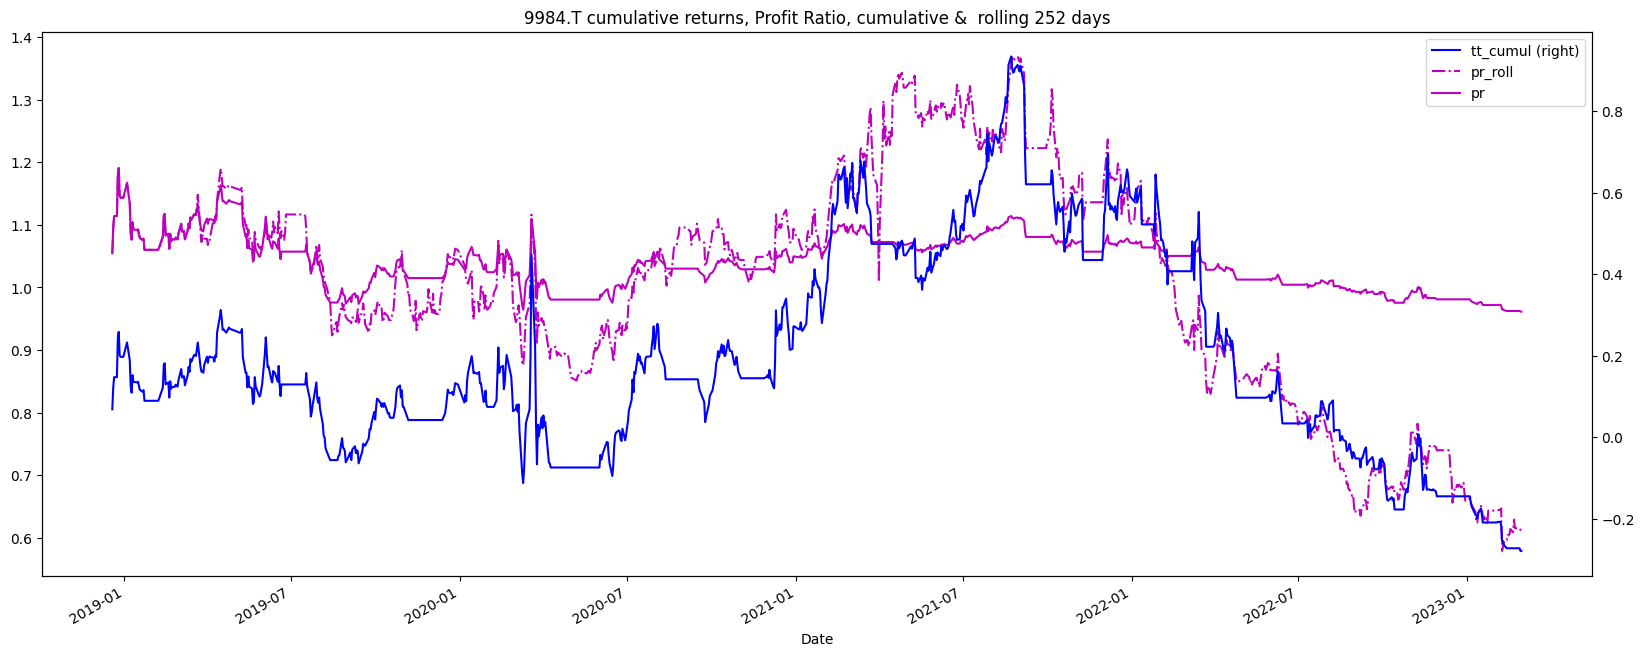

In [20]:
def rolling_profits(returns, window):
    profit_roll = returns.copy()
    profit_roll[profit_roll < 0] = 0
    profit_roll_sum = profit_roll.rolling(window).sum().fillna(method='ffill')
    return profit_roll_sum


def rolling_losses(returns, window):
    loss_roll = returns.copy()
    loss_roll[loss_roll > 0] = 0
    loss_roll_sum = loss_roll.rolling(window).sum().fillna(method='ffill')
    return loss_roll_sum


def expanding_profits(returns):
    profit_roll = returns.copy()
    profit_roll[profit_roll < 0] = 0
    profit_roll_sum = profit_roll.expanding().sum().fillna(method='ffill')
    return profit_roll_sum


def expanding_losses(returns):
    loss_roll = returns.copy()
    loss_roll[loss_roll > 0] = 0
    loss_roll_sum = loss_roll.expanding().sum().fillna(method='ffill')
    return loss_roll_sum


def profit_ratio(profits, losses):
    pr = profits.fillna(method='ffill') / abs(losses.fillna(method='ffill'))
    return pr


window = 252
df['pr_roll'] = profit_ratio(profits=rolling_profits(returns=tt_log_returns, window=window),
                             losses=rolling_losses(returns=tt_log_returns, window=window))
df['pr'] = profit_ratio(profits=expanding_profits(returns=tt_log_returns),
                        losses=expanding_losses(returns=tt_log_returns))

df[window:][['tt_cumul', 'pr_roll', 'pr']].plot(figsize=(20, 8), secondary_y=['tt_cumul'],
                                                style=['b', 'm-.', 'm'],
                                                title=str(
                                                    ticker) + ' cumulative returns, Profit Ratio, cumulative &  rolling ' + str(
                                                    window) + ' days')

<Axes: title={'center': '9984.T cumulative returns, Tail Ratios: cumulative &  rolling 252 days'}, xlabel='Date'>

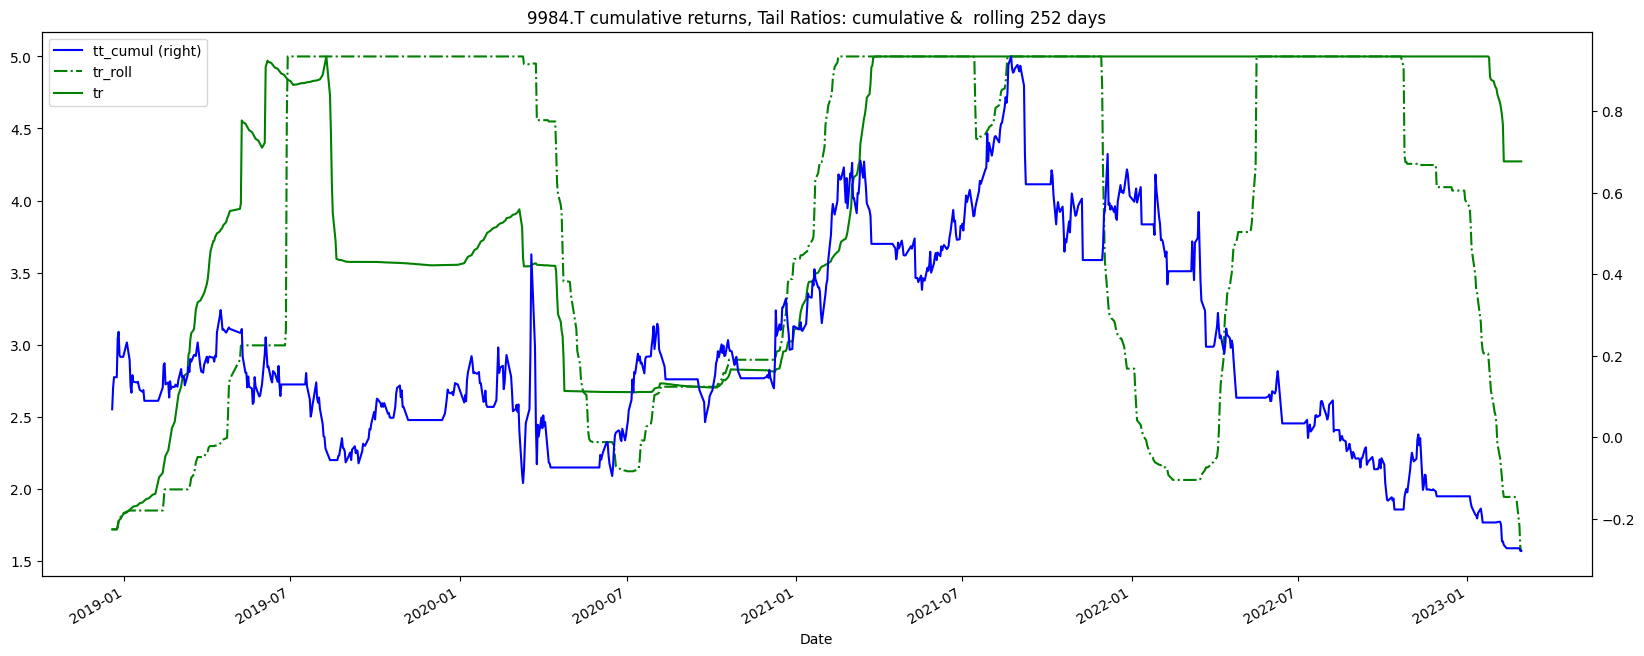

In [21]:
def rolling_tail_ratio(cumul_returns, window, percentile,limit):
    left_tail = np.abs(cumul_returns.rolling(window).quantile(percentile))
    right_tail = cumul_returns.rolling(window).quantile(1-percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail,limit),-limit)
    return tail

def expanding_tail_ratio(cumul_returns, percentile,limit):
    left_tail = np.abs(cumul_returns.expanding().quantile(percentile))
    right_tail = cumul_returns.expanding().quantile(1 - percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail,limit),-limit)
    return tail

df['tr_roll'] = rolling_tail_ratio(cumul_returns= df['tt_cumul'],
                                   window= window, percentile= 0.05,limit=5)
df['tr'] = expanding_tail_ratio(cumul_returns= df['tt_cumul'], percentile= 0.05,limit=5)

df[window:] [['tt_cumul','tr_roll','tr'] ].plot(secondary_y= ['tt_cumul'],style = ['b','g-.','g'], figsize = (20,8),
                                                title= str(ticker)+' cumulative returns, Tail Ratios: cumulative &  rolling '+str(window)+ ' days')